In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv


In [2]:
df =  pd.read_csv('../input/bengaluru-house-price-data/Bengaluru_House_Data.csv')

In [3]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


Drop features that are not required to build our model

In [4]:
df.drop(['area_type','society','balcony','availability'],axis='columns',inplace = True)

Checking nulls

In [5]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [6]:
df.shape

(13320, 5)

As nulls are quite less compared to the training data, we should drop them. We will still have sufficient data to train our model

In [7]:
df = df.dropna()
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

size seems to be categorical- let us make it continuous

In [8]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [9]:
df.drop('size',axis=1,inplace = True)
df.tail()

,location,total_sqft,bath,price,bhk
13315,Whitefield,3453,4.0,231.0,5
13316,Richards Town,3600,5.0,400.0,4
13317,Raja Rajeshwari Nagar,1141,2.0,60.0,2
13318,Padmanabhanagar,4689,4.0,488.0,4
13319,Doddathoguru,550,1.0,17.0,1


In [10]:
df['total_sqft'].plot(kind ='hist')

TypeError: no numeric data to plot

It says total_sqft is not numerical, let us check non numeric data

## Data Cleaning

In [11]:
df.loc[df['total_sqft'].str.isnumeric() == False]

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
44,Kanakpura Road,1330.74,2.0,91.790,2
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
142,Kasavanhalli,1563.05,3.0,105.000,3
...,...,...,...,...,...
13059,Harlur,1200 - 1470,2.0,72.760,2
13086,Sindhi Colony,5665.84,7.0,988.000,5
13123,9th Phase JP Nagar,1331.95,2.0,69.000,2
13265,Hoodi,1133 - 1384,2.0,59.135,2


It is taking decimals as non numeric, we need to take type conversions to help us here

In [12]:
def isfloat(element):
    try:
        float(element)
    except ValueError:
        return False
    return True

We have 190 string objects in total_sqft

In [13]:
df['total_sqft'].apply(isfloat).value_counts()

True     13056
False      190
Name: total_sqft, dtype: int64

In [14]:
df.loc[df['total_sqft'].apply(isfloat) == False].head(10)

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
410,Kengeri,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,63.770,2
648,Arekere,4125Perch,9.0,265.000,9
661,Yelahanka,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,3090 - 5002,4.0,445.000,4


Converting range to average of the values

In [15]:
temp2 = df.loc[ df['total_sqft'].str.contains("-") == True]

In [16]:
temp2

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...
12975,Whitefield,850 - 1060,2.0,38.190,2
12990,Talaghattapura,1804 - 2273,3.0,122.000,3
13059,Harlur,1200 - 1470,2.0,72.760,2
13265,Hoodi,1133 - 1384,2.0,59.135,2


In [17]:
temp3= temp2['total_sqft'].str.split('-')

In [18]:
temp3

30       [2100 ,  2850]
122      [3067 ,  8156]
137      [1042 ,  1105]
165      [1145 ,  1340]
188      [1015 ,  1540]
              ...      
12975     [850 ,  1060]
12990    [1804 ,  2273]
13059    [1200 ,  1470]
13265    [1133 ,  1384]
13299    [2830 ,  2882]
Name: total_sqft, Length: 144, dtype: object

In [19]:
temp3.index

Int64Index([   30,   122,   137,   165,   188,   549,   661,   672,   772,
              850,
            ...
            12334, 12435, 12544, 12791, 12955, 12975, 12990, 13059, 13265,
            13299],
           dtype='int64', length=144)

In [20]:
temp3[30][0]

'2100 '

In [21]:
for i in temp3.index:
    temp3[i] = (float(temp3[i][0])+float(temp3[i][1]))/2

In [22]:
temp3

30       2475.0
122      5611.5
137      1073.5
165      1242.5
188      1277.5
          ...  
12975     955.0
12990    2038.5
13059    1335.0
13265    1258.5
13299    2856.0
Name: total_sqft, Length: 144, dtype: object

Filling the required values

In [23]:
df.loc[df['total_sqft'].str.contains("-") == True,'total_sqft'] = temp3

In [24]:
del temp3,temp2
temp = df.loc[df['total_sqft'].apply(isfloat) == False]

In [25]:
temp.shape

(46, 5)

In [26]:
temp.head()

,location,total_sqft,bath,price,bhk
410,Kengeri,34.46Sq. Meter,1.0,18.5,1
648,Arekere,4125Perch,9.0,265.0,9
775,Basavanagara,1000Sq. Meter,2.0,93.0,1
872,Singapura Village,1100Sq. Yards,2.0,45.0,2
1019,Marathi Layout,5.31Acres,1.0,110.0,1


WE can remove these 46 rows as they can't be converted manually

In [27]:
df.drop(temp.index,inplace = True)

In [28]:
df.shape

(13200, 5)

In [29]:
#converting all the values to float
df['total_sqft'] = df['total_sqft'].apply(float)

<AxesSubplot:ylabel='Frequency'>

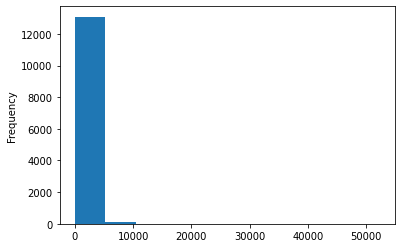

In [30]:
df['total_sqft'].plot(kind = 'hist')

Histogram plot is unusual, its range goes till 50000

In [31]:
temp2 = df.loc[df['total_sqft']>10000]
temp2

,location,total_sqft,bath,price,bhk
408,Rajaji Nagar,12000.0,6.0,2200.0,7
440,Whitefield,11890.0,4.0,700.0,4
605,Malleshwaram,12000.0,7.0,2200.0,7
674,Yelahanka,35000.0,3.0,130.0,3
810,4 Bedroom Farm House in Bagalur,10961.0,4.0,80.0,4
1234,Siddapura,14000.0,3.0,800.0,4
1894,Nelamangala,52272.0,2.0,140.0,3
2620,Sathya Sai Layout,11338.0,9.0,1000.0,6
2623,Dodsworth Layout,30000.0,4.0,2100.0,4
3096,Jp nagar 8th Phase .,12000.0,12.0,525.0,10


In [32]:
df['price'].dtype

dtype('float64')

<AxesSubplot:xlabel='total_sqft', ylabel='price'>

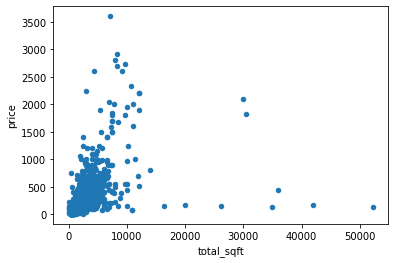

In [33]:
df.plot.scatter(x='total_sqft',y='price')

Let us create a new feature price per sq ft

In [34]:
df['price per square feet'] = df['price']/df['total_sqft']

In [37]:
df['price per square feet'].head()

0    0.036998
1    0.046154
2    0.043056
3    0.062459
4    0.042500
Name: price per square feet, dtype: float64

Let us assume we know that price per sq feet for each location lies between 1 normal and rest is outlier

In [43]:
for location in df['location']:
    mean = df.loc[df['location'] == location]['price per square feet'].mean()
    std = df.loc[df['location'] == location]['price per square feet'].std()
    less = df.loc[(df['location'] == location) & (df['price per square feet']<(mean-std))].index
    more  = df.loc[(df['location'] == location) & (df['price per square feet']>(mean+std))].index
    df.drop(less,inplace = True)
    df.drop(more,inplace =True)

<AxesSubplot:xlabel='total_sqft', ylabel='price'>

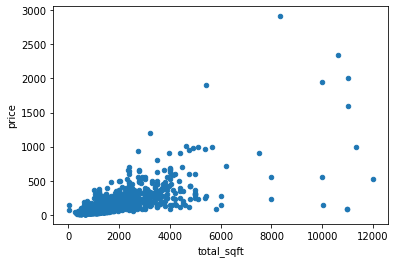

In [50]:
df.plot.scatter(x='total_sqft',y='price')

<AxesSubplot:ylabel='Frequency'>

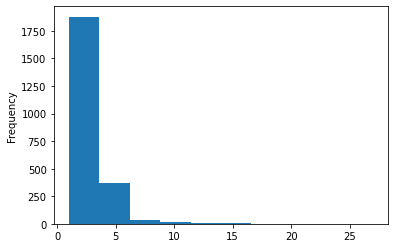

In [47]:
df['bath'].plot(kind = 'hist')

In [49]:
df.loc[df['bath']>12]

,location,total_sqft,bath,price,bhk,price per square feet
1078,BTM 1st Stage,3300.0,14.0,500.0,9,0.151515
1718,2Electronic City Phase II,8000.0,27.0,230.0,27,0.028750
3379,1Hanuman Nagar,2000.0,16.0,490.0,19,0.245000
3609,Koramangala Industrial Layout,10000.0,16.0,550.0,16,0.055000
4916,1Channasandra,1250.0,15.0,125.0,14,0.100000
9935,1Hoysalanagar,5425.0,13.0,275.0,13,0.050691
11559,1Kasavanhalli,1200.0,18.0,200.0,18,0.166667


In [54]:
counts = df.location.value_counts()
counts

Uttarahalli                                       23
TC Palaya                                         16
Chandapura                                        11
Kanakpura Road                                     9
HSR Layout                                         9
                                                  ..
Basvasamithi Layout Vidyaranyapura                 1
Badrappa Layout                                    1
Puttappa Layout                                    1
Ananthanagar Phase 1,Electronic City , phase 2     1
Abshot Layout                                      1
Name: location, Length: 1298, dtype: int64

There are total of 1298 locations available. Let us see bar chart with respect to them.

<AxesSubplot:>

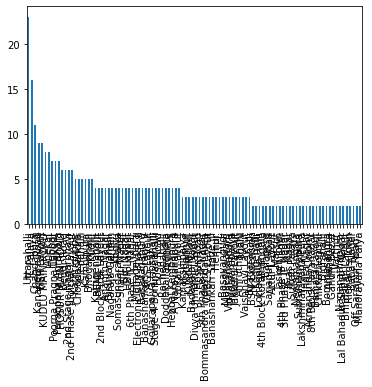

In [56]:
counts[0:100].plot(kind='bar')

In [60]:
counts[counts<2].count()

478

There are 478 values of 1

In [62]:
counts[counts==2].count()

753

and 753 with twice occuring location. We can safely mark them as others as training them as separate would not be meaningful and difficult. This is actually a technique in machine learning called Dimensionality Reduction.

## Dimensionality Reduction

In [73]:
temp4= counts[counts<=2].index
temp4

Index(['BSM Extension', 'Kodigehalli', 'Lottegolla Halli',
       '4th Block Koramangala', 'Balagere', 'Sarjapur  Road', 'Attur Layout',
       'Marsur', 'Tasker Town', '4th Phase JP Nagar',
       ...
       'Housing Board Layout Vijay Nagar', 't.c palya',
       'anjananager magdi road', 'kanakapura main road', 'Mailasandra',
       'Basvasamithi Layout Vidyaranyapura', 'Badrappa Layout',
       'Puttappa Layout', 'Ananthanagar Phase 1,Electronic City , phase 2',
       'Abshot Layout'],
      dtype='object', length=1231)

In [74]:
for location in temp4:
    df.loc[df['location'] == location,'location'] = 'others'

In [77]:
counts = df.location.value_counts()
counts

others                1984
Uttarahalli             23
TC Palaya               16
Chandapura              11
Kanakpura Road           9
                      ... 
Byadarahalli             3
ITPL                     3
Thigalarapalya           3
Malleshwaram             3
5th Phase JP Nagar       3
Name: location, Length: 68, dtype: int64

In [79]:
df = pd.concat([df,pd.get_dummies(df['location'])],axis=1)

In [80]:
df.drop('location',axis=1,inplace = True)
df.head(10)

,total_sqft,bath,price,bhk,price per square feet,2nd Block Hrbr Layout,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,...,Stage-4 Bommanahalli,TC Palaya,Thigalarapalya,Upkar Layout,Uttarahalli,VHBCS Layout,Vaishnavi Layout,Vidyaranyapura,Yelenahalli,others
6,2732.0,4.0,204.00,4,0.074671,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,1020.0,6.0,370.00,6,0.362745,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19,1100.0,2.0,48.00,2,0.043636,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24,510.0,1.0,25.25,1,0.049510,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
25,1250.0,3.0,56.00,3,0.044800,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
38,1290.0,2.0,56.12,3,0.043504,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
50,1270.0,2.0,50.00,2,0.039370,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
59,840.0,2.0,45.00,2,0.053571,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
60,4395.0,3.0,240.00,3,0.054608,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
61,845.0,2.0,55.00,2,0.065089,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Model building

We keep 33% as dev set size as this our full dataset is 13000. If it would have been in millions, dev set set of 1-5% would have been sufficient

In [90]:
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
X =df.drop('price',axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [104]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook

k_fold= KFold(n_splits= 4, random_state= 42)
algos1= {
        'Decision Tree Regressor' : {'model' : DecisionTreeRegressor(),
                                    'para' : {'criterion': ['mse'],
                                             'splitter': ['random'],'min_samples_split':[2,5,10,7]}
                                    },
        
        'Random Forest Regressor' : {'model' : RandomForestRegressor(),
                                     'para' :{'criterion' : ['mse'],'max_depth' : [1,5,7],
                                              'n_estimators':[50,100],
                                              'max_features': ['auto']}
                                    },
        'Linear regression ' : {'model': LinearRegression(),
                                    'para': {
                                        'normalize': [True, False]
                                    }}
        
        }
score1=[]
for algo, param in tqdm_notebook(algos1.items()):
    grid1= GridSearchCV(param['model'], param['para'], cv= k_fold)
    grid1.fit(X_train,y_train) 
    y_pred= grid1.predict(X_test)
    
    score1.append(pd.Series({
                'Estimator' : algo,
                'best parameter' : grid1.best_params_,
                'best score' : grid1.best_score_
                }))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

In [107]:
score1

[Estimator                                   Decision Tree Regressor
 best parameter    {'criterion': 'mse', 'min_samples_split': 2, '...
 best score                                                 0.840987
 dtype: object,
 Estimator                                   Random Forest Regressor
 best parameter    {'criterion': 'mse', 'max_depth': 7, 'max_feat...
 best score                                                 0.920446
 dtype: object,
 Estimator           Linear regression 
 best parameter    {'normalize': False}
 best score         -5759001221125802.0
 dtype: object]

Surely Linear Regression is not able to fit the data and is showing very large R squared value but our Random Forest Regressor works well!!

In [106]:
RF_obj = RandomForestRegressor(criterion='mse',max_depth =7,n_estimators=50,
                                              max_features='auto')
RF_obj.fit(X,y)

RandomForestRegressor(max_depth=7, n_estimators=50)

Export pickle file for model deployment

In [108]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(RF_obj,f)